In [69]:
import xtrack as xt
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xpart as xp
import xobjects as xo
import yaml
from matplotlib.ticker import ScalarFormatter
from scipy.optimize import curve_fit
import itertools
import nafflib as NAFFlib



In [71]:

#collider = xt.Multiline.from_json('/afs/cern.ch/work/a/aradosla/private/example_DA_study/studies/scans/example_tunescan/base_collider/collider.json')
collider = xt.Multiline.from_json('/afs/cern.ch/work/a/aradosla/private/example_DA_study/studies/scans/example_tunescan/base_collider/xtrack_0000/collider_final.json')





Loading line from dict: 100%|██████████| 43024/43024 [00:04<00:00, 8906.25it/s]


Done loading line from dict.           


Loading line from dict: 100%|██████████| 43098/43098 [00:04<00:00, 9408.24it/s]


Done loading line from dict.           


Loading line from dict: 100%|██████████| 42430/42430 [00:04<00:00, 9043.66it/s]


Done loading line from dict.           


Loading line from dict: 100%|██████████| 42504/42504 [00:04<00:00, 9252.87it/s]


Done loading line from dict.           


In [80]:
tw=collider['lhcb1'].twiss().qy
print(tw)

60.29513075852048


In [73]:

# Define radius distribution
r_min = 0
r_max = 10
n_r =  2 * 16 * (r_max - r_min)

radial_list = np.linspace(r_min, r_max, n_r, endpoint=False)

# Filter out particles with low and high amplitude to accelerate simulation
# radial_list = radial_list[(radial_list >= 4.5) & (radial_list <= 7.5)]

# Define angle distribution
n_angles = 30
theta_list = np.linspace(0, 90, n_angles + 2)[1:-1]
#theta_list = pd.DataFrame(theta_list)

# Define particle distribution as a cartesian product of the above
particle_list = [
    (particle_id, ii[1], ii[0])
    for particle_id, ii in enumerate(itertools.product(theta_list, radial_list))
]
85
particle_df = pd.DataFrame(particle_list, columns=["particle_id", "normalized amplitude in xy-plane", "angle in xy-plane [deg]"])


r_vect = particle_df["normalized amplitude in xy-plane"].values
theta_vect = particle_df["angle in xy-plane [deg]"].values * np.pi / 180  # type: ignore # [rad]

A1_in_sigma = r_vect * np.cos(theta_vect)
A2_in_sigma = r_vect * np.sin(theta_vect)

particles = collider['lhcb1'].build_particles(
    x_norm=A1_in_sigma,
    y_norm=A2_in_sigma,
    delta=0.,
    nemitt_x=(1.5e-6),
    nemitt_y=(1.5e-6)
)

particle_id = particle_df.particle_id.values




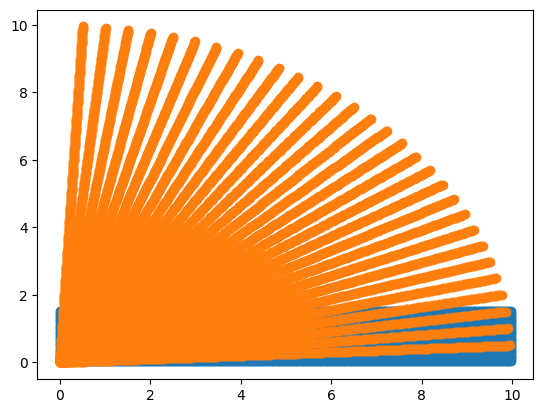

In [74]:
plt.plot(r_vect, theta_vect, 'o')
plt.plot(A1_in_sigma, A2_in_sigma, 'o')

In [75]:
num_turns = 10
tracker = collider['lhcb1'].track(particles, turn_by_turn_monitor=True, num_turns=num_turns, freeze_longitudinal=True)

In [76]:
tbt_x = collider['lhcb1'].record_last_track.x.flatten() # particle_id, turns
tbt_y = collider['lhcb1'].record_last_track.y.flatten() # particle_id, turns
particles_id = collider['lhcb1'].record_last_track.particle_id.flatten()
turns = collider['lhcb1'].record_last_track.at_turn.flatten()
df = pd.DataFrame({'particle_id': particles_id, 'x': tbt_x, 'y': tbt_y, 'turn': turns} )

keys = []
qx_tot1 = []
qx_tot2 = []
qy_tot1 = []
qy_tot2 = []
diffusions = []
for key, group in df.groupby('particle_id'):
    qx1 = abs(NAFFlib.get_tune(group.x.values[:2000], 2))
    qy1 = abs(NAFFlib.get_tune(group.y.values[:2000], 2))
    qx2 = abs(NAFFlib.get_tune(group.x.values[-2000:], 2))
    qy2 = abs(NAFFlib.get_tune(group.y.values[-2000:], 2))
    qx_tot1.append(qx1)
    qy_tot1.append(qy1)
    qx_tot2.append(qx2)
    qy_tot2.append(qy2)
    keys.append(key)
    diffusion = np.sqrt( abs(qx1-qx2)**2 + abs(qy1-qy2)**2 )
    if diffusion==0.0:
        diffusion=1e-60
    diffusion = np.log10(diffusion)
    diffusions.append(diffusion)
dff = pd.DataFrame({'particle_id': keys,'qx1': qx_tot1, 'qy1': qy_tot1, 'qx2':qx_tot2, 'qy2':qy_tot2, 'diffusion': diffusions} )
dff = dff.merge(particle_df, on='particle_id')
dff.to_parquet(f'fma.parquet')

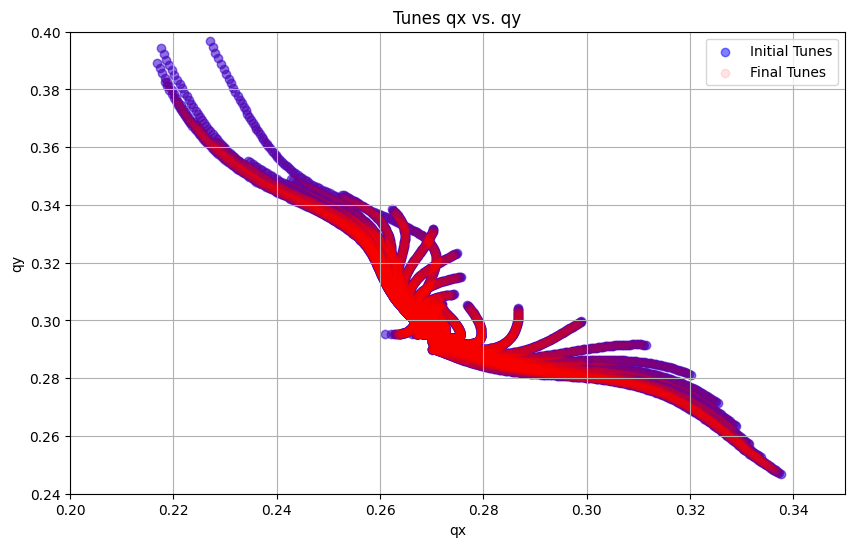

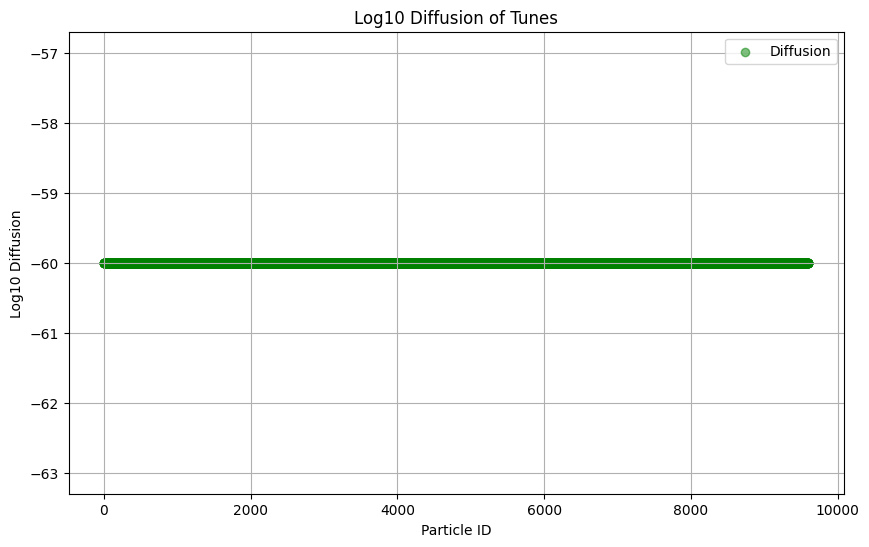

In [79]:
# Scatter plot of initial tunes qx1 vs. qy1
%matplotlib inline
plt.figure(figsize=(10, 6))
plt.scatter(dff['qx1'], dff['qy1'], c='blue', label='Initial Tunes', alpha=0.5)
plt.xlabel('qx1')
plt.ylabel('qy1')
plt.title('Initial Tunes qx1 vs. qy1')
plt.legend()
plt.grid(True)

# Scatter plot of final tunes qx2 vs. qy2

plt.scatter(dff['qx2'], dff['qy2'], c='red', label='Final Tunes', alpha=0.1)
plt.xlabel('qx')
plt.ylabel('qy')
plt.title('Tunes qx vs. qy')
plt.legend()
plt.grid(True)
plt.xlim(0.2, 0.35)
plt.ylim(0.24, 0.4)
plt.show()

# Diffusion plot
plt.figure(figsize=(10, 6))
plt.scatter(dff['particle_id'], dff['diffusion'], c='green', label='Diffusion', alpha=0.5)
plt.xlabel('Particle ID')
plt.ylabel('Log10 Diffusion')
plt.title('Log10 Diffusion of Tunes')
plt.legend()
plt.grid(True)

plt.show()


In [47]:
tw= collider['lhcb1'].twiss()

In [51]:
tw.keys()

dict_keys(['name', 's', 'x', 'px', 'y', 'py', 'zeta', 'delta', 'ptau', 'W_matrix', 'kin_px', 'kin_py', 'kin_ps', 'kin_xprime', 'kin_yprime', 'betx', 'bety', 'alfx', 'alfy', 'gamx', 'gamy', 'dx', 'dpx', 'dy', 'dpy', 'dx_zeta', 'dpx_zeta', 'dy_zeta', 'dpy_zeta', 'betx1', 'bety1', 'betx2', 'bety2', 'mux', 'muy', 'muzeta', 'nux', 'nuy', 'nuzeta', 'dzeta', 'only_markers', 'particle_on_co', 'circumference', 'orientation', 'R_matrix', 'steps_r_matrix', 'R_matrix_ebe', 'slip_factor', 'momentum_compaction_factor', 'bets0', 'T_rev0', 'gamma0', 'beta0', 'p0c', 'qx', 'qy', 'qs', 'c_minus', 'c_r1_avg', 'c_r2_avg', 'eigenvalues', 'rotation_matrix', 'dmux', 'dmuy', 'bx_chrom', 'by_chrom', 'ax_chrom', 'ay_chrom', 'wx_chrom', 'wy_chrom', 'ddx', 'ddpx', 'ddy', 'ddpy', 'dqx', 'dqy', 'ddqx', 'ddqy', 'values_at', 'method', 'radiation_method', 'reference_frame', 'line_config', '_action'])

In [55]:
tw.qx

62.30985150351693